# **Distinctiveness of Behavior for Each Parameter Value**

#### - Graphing the correlation between simulated and recovered parameters alone gives a false impression of how well the model was fit (MLE), given the low number of trials per subgroup. 
- If Ss behave identically across different parameterers combinations (*i.e., same proportion of trials per subgroup in which lottery is chosen*), it becomes impossible for parameter recovery to correctly link specific parameters with bahavior.
### ***Important Factors***
- Precision for proportion of trials in which Ss chose the lottery option 
    - Number of trials per subgroup (*specific combination of probability, ambiguity, lottery value*)
        - There are only 3 possible values for the proportion of trials when given only 2 trials per subgroup [0, 0.5, 1], meaning the ability to differentiate every possible combination of alpha, beta, and gamma is severely handicapped.
        - With only 2 trials per subgroup, only 0.05 of discretized parameter space is able to be differentiated (not even varying gamma).
    - Both precision of proportion of trials and LL calculation are heavily affected by the number of trials per subgroup 
        - Even if this relationship is obscured within Scipy's Bernouilli logpmf()
- Number of levels for each condition (probability, ambiguity, lottery value)
    - Provides opportunity for Ss behavior to be differentiated

### ***Conclusion***
- To get accurate parameter recovery, distinctiveness in behavior (*quantified as precision of proportion of trials in which Ss chose lottery*) must exist across parameter combinations, which is directly influenced by the number of trials per subgroup (*i.e., combinations of levels of conditions*)
- Ultimately, better recovery of parameters is achieved through increasing the number of trials per condition subgroup than by adding an additional level of condition (i.e., ambiguity)
    - While adding an additional level of ambiguity does marginally increase beta recovery, it is less impactful than adding more trials per subgroup.


## **--METHODOLOGICAL DECISIONS--**
#### Limitations

- TIME (Task length)
    - Construct validity for our pain manipulation requires cextensive ISI between heat application (~20-25 seconds)
    - As task duration increases, so too does possibility of Ss fatigue or disengagement
- MODELING REQUIREMENTS (Parameter recovery)
    - Accurate model fitting/parameter recovery requires a certain number of trials for each condition group (*determined by the number of levels of probability, ambiguity, and lottery value*). 
        - MLE-specific concerns: more trials per subgroup = higher resolution in possible Ss behavior (*see above*)
            - Parameters can be linked to specific behavior
        - Fitting/recovery of beta requires ~100 trials per subgroup if fitted simultaneously with alpha and gamma; however, if alpha and gamma are fit first, then beta requires ~15 trials per subgroup to be accurately recovered
        - Alpha recovery is not great either with only 2 trials per condition subgroup
    - Everything represented in this notebook is *even more optimistic than reality* because gamma has been held constant at 1.5 (low stochasticity)
- OPTIONS FOR CCB CRDM EXPERIMENT TO IMPROVE PARAMETER FITS
    - **OPTION #1.** *Remove ambiguity trials and hold beta constant at 0*.
        - SV(option) = p * v**alpha
        - PROS
            - This option permits redistribution of 24 ambiguity trials back to risk conditions: 3 trials per subgroup, thus improving the distinctiveness of risk behavior
                - Saves 4 per pain condition!
        - CONS
            -Lose ambiguity tolerance (beta)
    - **OPTION #2.** *Use QuestPlus to adaptively identify the most informative condition combinations for each Ss*
        - Running all risk trials first, use alpha and gamma to adapt trials for beta
            - ~22 trials required for alpha and gamma
            - ~42 trials required for beta
        - PROS
            - Better beta fit in fewer trials
            - Better alpha/gamma fit in fewer trials
        - CONS
            - Variable number of trials per condition subgroup
                - Some subgroups may not be sampled at all
            - QuestPlus treats Ss like predictable machines - as if people view each trial independently
                - Loves to present the same condition combo repeatedly and sometimes consecutively


In [1]:
"""
===================
Mandy Renfro (2024)
===================
"""

import numpy as np
import os
import os.path, sys
import pylab as plt
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

base_proj_dir = "Z:/data/CCB" ## base project directory
save_dir = os.path.join(base_proj_dir, "derivatives/simulations/crdm/distinctiveness") ## save directory for CRDM simulations
if not os.path.exists(save_dir): ## new Ss
    os.makedirs(save_dir) ## make new Ss save directory

def probability_of_lottery_choice(alpha, beta, gamma, lottery_value, certain_value, ambiguity, probability):
    """ Determines probability of selecting lottery using the Softmax probabilitic function
        INPUT:
        - alpha: current Ss risk parameter [high values indicate risk seeking]
        - beta: current Ss ambiguity parameter [high values indicate ambiguity avoidance]
        - gamma: current Ss choice stochasticity parameter [high values indicate more noise]
        - lottery_value: current condition combo winning lottery amount 
        - certain_value: current condition combo certain amount
        - ambiguity: current condition combo ambiguity level
        - probability: current condition combo probability level
        OUTPUT:
        - Ss probability of choosing lottery for trials with the current condition combination 
    """
    SV_lottery, SV_certain = SVs(alpha, beta, lottery_value, certain_value, ambiguity, probability)
    return 1 / (1 + np.exp(-gamma * (SV_lottery - SV_certain))) 

def score_distinctiveness(tiles):
    """ Calculates distinctiveness of behavior across parameters for each condition subgroup
        INPUT:
        - tiles: 
        OUTPUT:
        - Distinctiveness score
        - Number of indistinguishable clusters
    """
    groups = np.zeros(tiles.shape[0])
    group_num = 0
    bad_groups = 0
    for i, _ in enumerate(tiles):
        if groups[i] == 0:
            idx = np.where(np.all(tiles[i] == tiles[:], axis = 1))
            if idx[0].shape[0] == 1: ## unique groups with 1 number
                group_num += 1
                groups[idx] = group_num
            else: ## non-distinct groups
                bad_groups -= 1
                groups[idx] = bad_groups
    print("Distinctiveness:", np.max(groups)/groups.shape[0])
    print("Number of indistinguishable clusters:", abs(bad_groups))
    print("Similarity:", 1 - np.max(groups)/groups.shape[0])
    return np.max(groups)/groups.shape[0], abs(bad_groups), 1 - np.max(groups)/groups.shape[0]

def SVs(alpha, beta, lottery_value, certain_value, ambiguity, probability):
    """ Calculate SV for lottery and safe options given current trial condition combo (Gilboa & Schmeidler, 1989)
        *Note: np.sign() and np.abs() allows this function to flexibly handle *both* gain and loss trials
        INPUT:
        - alpha: current Ss alpha
        - beta: current Ss beta
        - lottery_value: winning lottery amount for current condition combo
        - ambiguity: ambiguity level for current condition combo
        - probability: probability for current condition combo
        OUTPUT:
        - SV_lottery: subjective value for lottery option for current trial condition combination
        - SV_certain: subjective value for certain option fr current trial condition combination
    """
    SV_lottery = (probability - beta * ambiguity / 2) * lottery_value**alpha
    SV_certain = certain_value**alpha
    return SV_lottery, SV_certain

certain_value = 5
lottery_range = [8, 25, 40, 50]

## **ALPHA**

#### Alpha Distinctiveness: Number of Trials Per Condition Subgroup = 2
- Gamma constant (1.5)
- Risk trials only
    - Ambiguity = 0

ALPHA n=2
Distinctiveness: 0.6470588235294118
Number of indistinguishable clusters: 2
Similarity: 0.3529411764705882
Saving to: Z:/data/SDDM\derivatives/simulations/crdm/distinctiveness\distinctiveness-alpha_cG-5probs-2trials.png


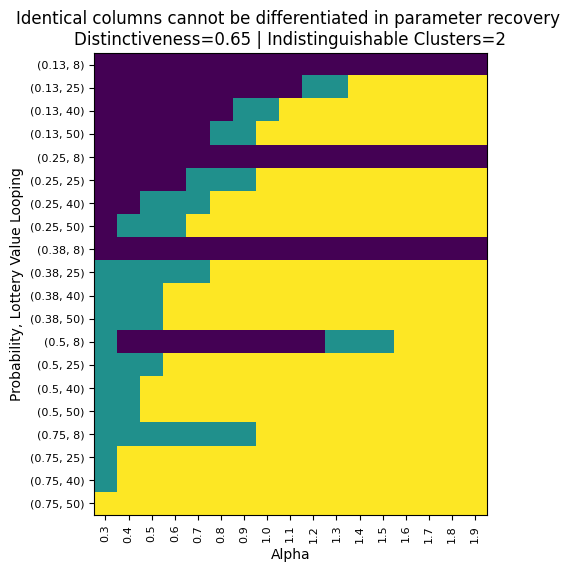

In [69]:
alphas = np.round(np.arange(0.3, 2, 0.1), 2) ## parameter space sampling
probability_range = [0.13, 0.25, 0.38, 0.50, 0.75] ## list of risk trial probabilities
## 2D numpy array with zeros with number of columns = alpha length and number of rows = number of risk trial condition combo
tiles = np.zeros((alphas.shape[0], len(lottery_range) * len(probability_range))) 

n_trials_per_subgroup = 2 ## number of trials per condition combo

for y, prob in enumerate(probability_range): ## each probability
    for x2, lottery in enumerate(lottery_range): ## each lottery value
        tile = np.zeros((alphas.shape[0], 1)) ## create row for current condition combo
        for ia, alpha in enumerate(alphas): ## each alpha
            p_ideal = probability_of_lottery_choice(alpha, 0, 1.5, lottery, certain_value, 0, prob) ## calculate prob of lottery choice with infinite precision
            p_trial_based = np.round(n_trials_per_subgroup * p_ideal, 0) / n_trials_per_subgroup ## calculate prob of lottery choice with only two trials
            tile[ia, 0] = p_trial_based ## observed avg prob for current alpha given condition combo 
        x = x2 + len(lottery_range) * y ## variable for reshaping heatmap
        tiles[0 * tile.shape[0] : 0 * tile.shape[0] + tile.shape[0], x * tile.shape[1] : x * tile.shape[1] + tile.shape[1]] = tile ## reshaping heatmap rows/columns
print("ALPHA n=2") ## number of trials per condition subgroup
res = score_distinctiveness(tiles) ## distinctiveness score and indistinguishable clusters
heatmap = tiles.T ## transpose the heatmap
fig, ax = plt.subplots(figsize=(6, 6))
plt.imshow(heatmap) ## display heatmap
plt.xlabel("Alpha") ## x-axis title
plt.xticks(np.arange(heatmap.shape[1]), alphas.tolist(), rotation = 90, fontsize = 8) ## define x-axis values
plt.ylabel("Probability, Lottery Value Looping") ## y-axis title
plt.title("Identical columns cannot be differentiated in parameter recovery \nDistinctiveness={0:.2f} | Indistinguishable Clusters={1}".format(res[0], res[1]))
lottery_ticks = []
for p in probability_range: ## create respective y-axis values
    lottery_ticks.extend(zip([p] * len(lottery_range), lottery_range))
plt.yticks(np.arange(heatmap.shape[0]), lottery_ticks, fontsize = 8) ## define x-axis values
fig_name = os.path.join(save_dir, "distinctiveness-alpha_cG-5probs-2trials.png") ## filename
print("Saving to: {}".format(fig_name)) ## indicate save location
plt.savefig(fig_name) ## save figure
plt.show()

#### Alpha Distinctiveness: Number of Trials Per Condition Subgroup = 3

ALPHA n=3
Distinctiveness: 0.7058823529411765
Number of indistinguishable clusters: 2
Similarity: 0.2941176470588235
Saving to: Z:/data/SDDM\derivatives/simulations/crdm/distinctiveness\distinctiveness-alpha_cG-5probs-3trials.png


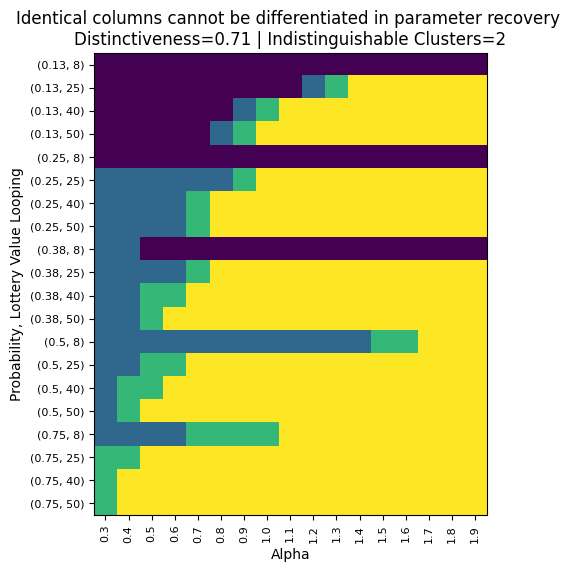

In [70]:
alphas = np.round(np.arange(0.3, 2, 0.1), 2)
probability_range = [0.13, 0.25, 0.38, 0.50, 0.75]
tiles = np.zeros((alphas.shape[0], len(lottery_range) * len(probability_range)))

n_trials_per_subgroup = 3

for y, prob in enumerate(probability_range):
    for x2, lottery in enumerate(lottery_range):
        tile = np.zeros((alphas.shape[0], 1))
        for ia, alpha in enumerate(alphas):
            p_ideal = probability_of_lottery_choice(alpha, 0, 1.5, lottery, certain_value, 0, prob)
            p_trial_based = np.round(n_trials_per_subgroup * p_ideal, 0) / n_trials_per_subgroup
            tile[ia, 0] = p_trial_based
        x = x2 + len(lottery_range) * y
        tiles[0 * tile.shape[0] : 0 * tile.shape[0] + tile.shape[0], x * tile.shape[1] : x * tile.shape[1] + tile.shape[1]] = tile
print("ALPHA n=3")
res = score_distinctiveness(tiles)
heatmap = tiles.T
fig, ax = plt.subplots(figsize=(6, 6))
plt.imshow(heatmap)
plt.xlabel("Alpha")
plt.xticks(np.arange(heatmap.shape[1]), alphas.tolist(), rotation = 90, fontsize = 8)
plt.ylabel("Probability, Lottery Value Looping")
plt.title("Identical columns cannot be differentiated in parameter recovery \nDistinctiveness={0:.2f} | Indistinguishable Clusters={1}".format(res[0], res[1]))
lottery_ticks = []
for p in probability_range:
    lottery_ticks.extend(zip([p] * len(lottery_range), lottery_range))
plt.yticks(np.arange(heatmap.shape[0]), lottery_ticks, fontsize = 8)
fig_name = os.path.join(save_dir, "distinctiveness-alpha_cG-5probs-3trials.png")
print("Saving to: {}".format(fig_name))
plt.savefig(fig_name)
plt.show()

#### Alpha Distinctiveness: Removing Prop = 75% | Increasing Number of Trials Per Condition Subgroup = 2

ALPHA n=3
Distinctiveness: 0.6470588235294118
Number of indistinguishable clusters: 2
Similarity: 0.3529411764705882
Saving to: Z:/data/SDDM\derivatives/simulations/crdm/distinctiveness\distinctiveness-alpha_cG-4probs-2trials.png


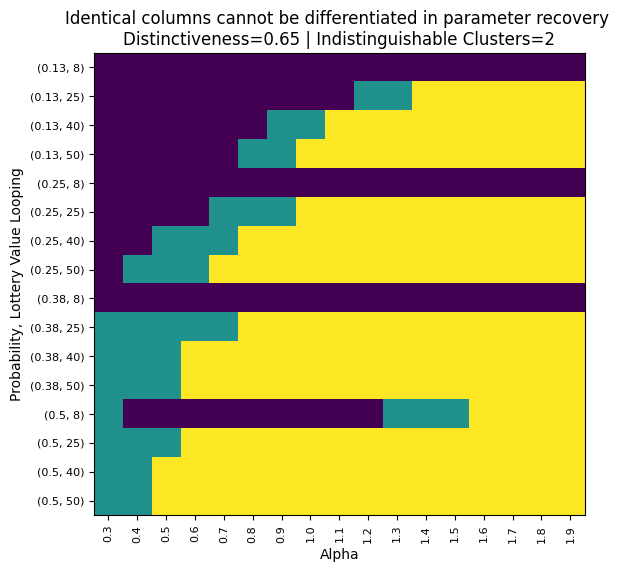

In [71]:
alphas = np.round(np.arange(0.3, 2, 0.1), 2)
probability_range = [0.13, 0.25, 0.38, 0.50]
tiles = np.zeros((alphas.shape[0], len(lottery_range) * len(probability_range)))

n_trials_per_subgroup = 2

for y, prob in enumerate(probability_range):
    for x2, lottery in enumerate(lottery_range):
        tile = np.zeros((alphas.shape[0], 1))
        for ia, alpha in enumerate(alphas):
            p_ideal = probability_of_lottery_choice(alpha, 0, 1.5, lottery, certain_value, 0, prob)
            p_trial_based = np.round(n_trials_per_subgroup * p_ideal, 0) / n_trials_per_subgroup
            tile[ia, 0] = p_trial_based
        x = x2 + len(lottery_range) * y
        tiles[0 * tile.shape[0] : 0 * tile.shape[0] + tile.shape[0], x * tile.shape[1] : x * tile.shape[1] + tile.shape[1]] = tile
print("ALPHA n=3")
res = score_distinctiveness(tiles)
heatmap = tiles.T
fig, ax = plt.subplots(figsize=(7, 6))
plt.imshow(heatmap)
plt.xlabel("Alpha")
plt.xticks(np.arange(heatmap.shape[1]), alphas.tolist(), rotation = 90, fontsize = 8)
plt.ylabel("Probability, Lottery Value Looping")
plt.title("Identical columns cannot be differentiated in parameter recovery \nDistinctiveness={0:.2f} | Indistinguishable Clusters={1}".format(res[0], res[1]))
lottery_ticks = []
for p in probability_range:
    lottery_ticks.extend(zip([p] * len(lottery_range), lottery_range))
plt.yticks(np.arange(heatmap.shape[0]), lottery_ticks, fontsize = 8)
fig_name = os.path.join(save_dir, "distinctiveness-alpha_cG-4probs-2trials.png")
print("Saving to: {}".format(fig_name))
plt.savefig(fig_name)
plt.show()

#### Alpha Distinctiveness: Number of Trials Per Condition Subgroup = 8

ALPHA n=8
Distinctiveness: 1.0
Number of indistinguishable clusters: 0
Similarity: 0.0
Saving to: Z:/data/SDDM\derivatives/simulations/crdm/distinctiveness\distinctiveness-alpha_cG-5probs-8trials.png


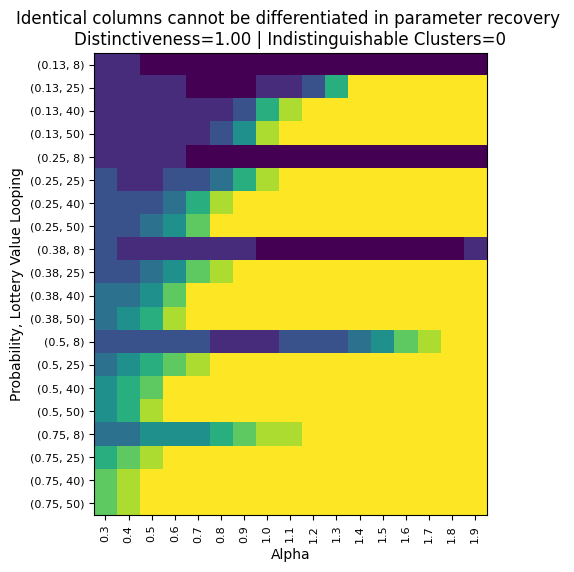

In [72]:
alphas = np.round(np.arange(0.3, 2, 0.1), 2)
probability_range = [0.13, 0.25, 0.38, 0.50, 0.75]
tiles = np.zeros((alphas.shape[0], len(lottery_range) * len(probability_range)))

n_trials_per_subgroup = 8

for y, prob in enumerate(probability_range):
    for x2, lottery in enumerate(lottery_range):
        tile = np.zeros((alphas.shape[0], 1))
        for ia, alpha in enumerate(alphas):
            p_ideal = probability_of_lottery_choice(alpha, 0, 1.5, lottery, certain_value, 0, prob)
            p_trial_based = np.round(n_trials_per_subgroup * p_ideal, 0) / n_trials_per_subgroup
            tile[ia, 0] = p_trial_based
        x = x2 + len(lottery_range) * y
        tiles[0 * tile.shape[0] : 0 * tile.shape[0] + tile.shape[0], x * tile.shape[1] : x * tile.shape[1] + tile.shape[1]] = tile
print("ALPHA n=8")
res = score_distinctiveness(tiles)
heatmap = tiles.T
fig, ax = plt.subplots(figsize=(6, 6))
plt.imshow(heatmap)
plt.xlabel("Alpha")
plt.xticks(np.arange(heatmap.shape[1]), alphas.tolist(), rotation = 90, fontsize = 8)
plt.ylabel("Probability, Lottery Value Looping")
plt.title("Identical columns cannot be differentiated in parameter recovery \nDistinctiveness={0:.2f} | Indistinguishable Clusters={1}".format(res[0], res[1]))
lottery_ticks = []
for p in probability_range:
    lottery_ticks.extend(zip([p] * len(lottery_range), lottery_range))
plt.yticks(np.arange(heatmap.shape[0]), lottery_ticks, fontsize = 8)
fig_name = os.path.join(save_dir, "distinctiveness-alpha_cG-5probs-8trials.png")
print("Saving to: {}".format(fig_name))
plt.savefig(fig_name)
plt.show()

In [ ]:
import numpy as np
from scipy.stats import bernoulli

MLL_trials = np.array([2.0, 1.0, 1.0]) ## each value represents the sum of lottery choices in that condition subgroup | number of trials per subgroup = 2
MLL_probs  = np.array([1.0, 0.5, 0.7]) ## probability (predictive - not proportion) Ss will chose lottery for each condition subgroup
MLL_total_trials = np.array([2, 2, 2]) ## number of trials per subgroup
print("No black box LL:    ", np.nansum(np.log(MLL_probs) * MLL_trials + np.log(1 - MLL_probs) * (MLL_total_trials - MLL_trials)))

BLL_trials = np.array([1.0, 1.0, 0.0, 1.0, 1.0, 0.0])
BLL_probs  = np.array([1.0, 1.0, 0.5, 0.5, 0.7, 0.7])
print("Bernoulli logpmf LL:", np.nansum(bernoulli.logpmf(BLL_trials, BLL_probs)))

No black box LL:     -2.946942109384559
Bernoulli logpmf LL: -2.946942109384559


#### Alpha Distinctiveness: Different Prob Levels | Number of Trials Per Condition Subgroup = 2
- Estimates parameter recovery if people behaved precisely as expected by the RA Model
- When I ran the simulation and parameter recovery for replacing 0.75 with 0.44 -- all other stats were worse (but optimal behavior was more distinct!)

ALPHA n=3
Distinctiveness: 0.7647058823529411
Number of indistinguishable clusters: 2
Similarity: 0.23529411764705888
Saving to: Z:/data/SDDM\derivatives/simulations/crdm/distinctiveness\distinctiveness-alpha_cG-5probs44-2trials.png


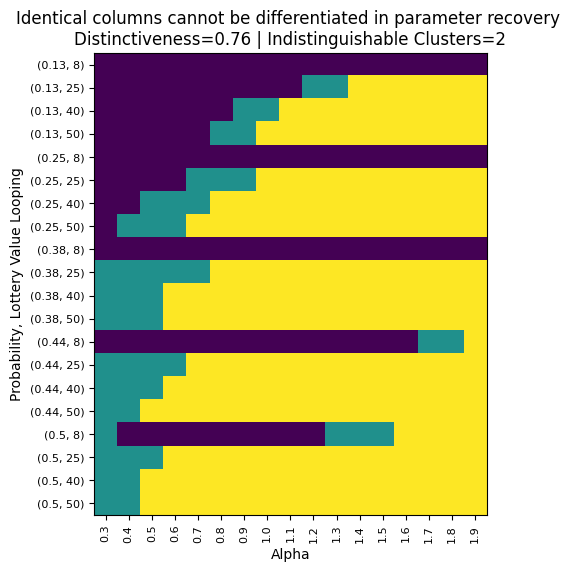

In [73]:
alphas = np.round(np.arange(0.3, 2, 0.1), 2)
probability_range = [0.13, 0.25, 0.38, 0.44, 0.50]
tiles = np.zeros((alphas.shape[0], len(lottery_range) * len(probability_range)))

n_trials_per_subgroup = 2

for y, prob in enumerate(probability_range):
    for x2, lottery in enumerate(lottery_range):
        tile = np.zeros((alphas.shape[0], 1))
        for ia, alpha in enumerate(alphas):
            p_ideal = probability_of_lottery_choice(alpha, 0, 1.5, lottery, certain_value, 0, prob)
            p_trial_based = np.round(n_trials_per_subgroup * p_ideal, 0) / n_trials_per_subgroup
            tile[ia, 0] = p_trial_based
        x = x2 + len(lottery_range) * y
        tiles[0 * tile.shape[0] : 0 * tile.shape[0] + tile.shape[0], x * tile.shape[1] : x * tile.shape[1] + tile.shape[1]] = tile
print("ALPHA n=3")
res = score_distinctiveness(tiles)
heatmap = tiles.T
fig, ax = plt.subplots(figsize=(6, 6))
plt.imshow(heatmap)
plt.xlabel("Alpha")
plt.xticks(np.arange(heatmap.shape[1]), alphas.tolist(), rotation = 90, fontsize = 8)
plt.ylabel("Probability, Lottery Value Looping")
plt.title("Identical columns cannot be differentiated in parameter recovery \nDistinctiveness={0:.2f} | Indistinguishable Clusters={1}".format(res[0], res[1]))
lottery_ticks = []
for p in probability_range:
    lottery_ticks.extend(zip([p] * len(lottery_range), lottery_range))
plt.yticks(np.arange(heatmap.shape[0]), lottery_ticks, fontsize = 8)
fig_name = os.path.join(save_dir, "distinctiveness-alpha_cG-5probs44-2trials.png")
print("Saving to: {}".format(fig_name))
plt.savefig(fig_name)
plt.show()

## **BETA**

#### Beta Distinctiveness: Number of Ambiguity Levels (3) | Trials Per Condition Subgroup (2)

BETA  n=2
Distinctiveness: 0.05429864253393665
Number of indistinguishable clusters: 37
Similarity: 0.9457013574660633
Saving to: Z:/data/SDDM\derivatives/simulations/crdm/distinctiveness\distinctiveness-beta_vAcG-3ambs-2trials.png


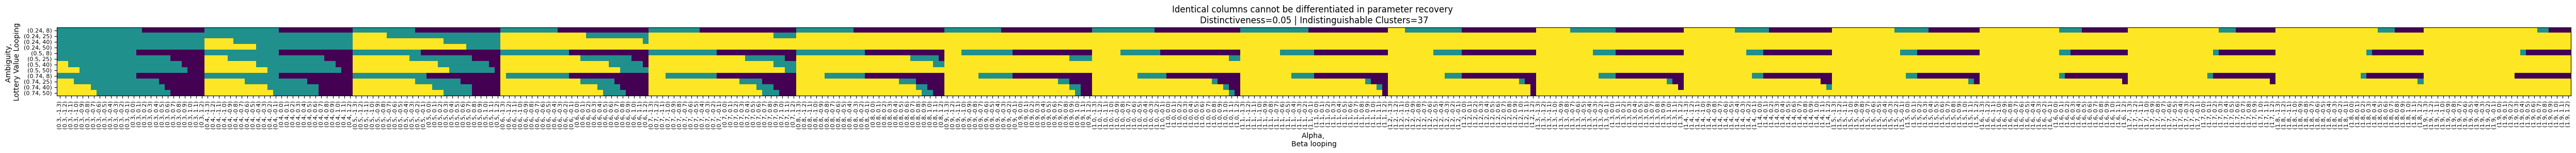

In [3]:
alphas = np.round(np.arange( 0.3,   2,  0.1), 2)
betas  = np.round(np.arange(-1.3, 1.3,  0.1), 2)
ambiguity_range = [0.24, 0.5, 0.74]
tiles = np.zeros((alphas.shape[0] * betas.shape[0], len(ambiguity_range) * len(lottery_range)))

n_trials_per_subgroup = 2

for y2, ambiguity in enumerate(ambiguity_range):
    for x2, lottery in enumerate(lottery_range):
        tile = np.zeros((betas.shape[0], 1))
        x = x2 + len(lottery_range) * y2
        for ia, alpha in enumerate(alphas):
            for kb, beta in enumerate(betas):
                p_ideal = probability_of_lottery_choice(alpha, beta, 1.5, lottery, certain_value, ambiguity, 0.5)
                p_trial_based = np.round(n_trials_per_subgroup * p_ideal, 0) / n_trials_per_subgroup
                tile[kb, 0] = p_trial_based
            y = ia
            tiles[y * tile.shape[0] : y * tile.shape[0] + tile.shape[0], x * tile.shape[1] : x * tile.shape[1] + tile.shape[1]] = tile
print("BETA  n=2")
res = score_distinctiveness(tiles)
heatmap = tiles.T
fig, ax = plt.subplots(figsize=(50, 5))
plt.imshow(heatmap)
plt.title("Identical columns cannot be differentiated in parameter recovery \nDistinctiveness={0:.2f} | Indistinguishable Clusters={1}".format(res[0], res[1]))
plt.xlabel("Alpha, \nBeta looping")
beta_ticks = []
for a in alphas:
    beta_ticks.extend(zip([a] * betas.shape[0], betas))
plt.xticks(np.arange(heatmap.shape[1]), beta_ticks, rotation = 90, fontsize = 8)
plt.ylabel("Ambiguity, \nLottery Value Looping")
lottery_ticks = []
for a2 in ambiguity_range:
    lottery_ticks.extend(zip([a2] * len(lottery_range), lottery_range))
plt.yticks(np.arange(heatmap.shape[0]), lottery_ticks, fontsize = 8)
plt.tight_layout()
fig_name = os.path.join(save_dir, "distinctiveness-beta_vAcG-3ambs-2trials.png")
print("Saving to: {}".format(fig_name))
plt.savefig(fig_name)
plt.show()

#### Beta Distinctiveness: Number of Ambiguity Levels (4) | Trials Per Condition Subgroup (2)

BETA  n=2
Distinctiveness: 0.07239819004524888
Number of indistinguishable clusters: 47
Similarity: 0.9276018099547512
Saving to: Z:/data/SDDM\derivatives/simulations/crdm/distinctiveness\distinctiveness-beta_vAcG-4ambs-2trials.png


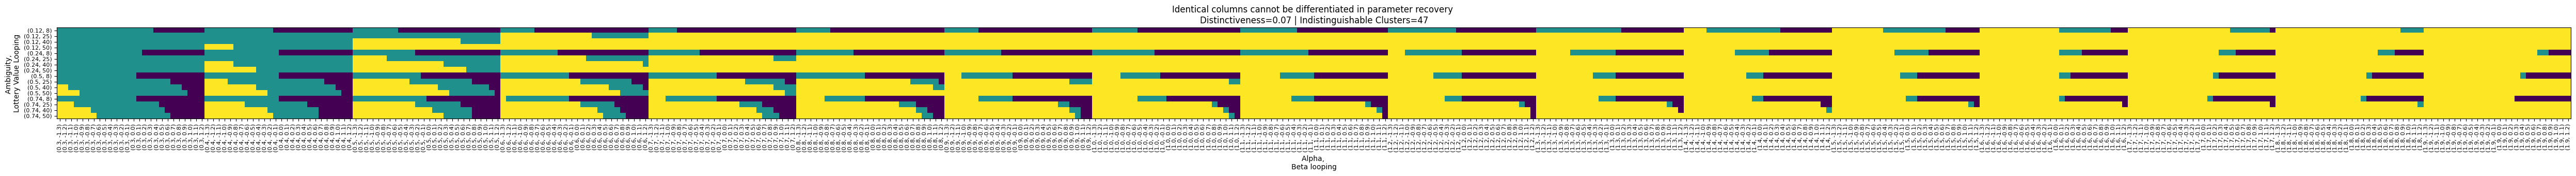

In [9]:
alphas = np.round(np.arange( 0.3,   2,  0.1), 2)
betas  = np.round(np.arange(-1.3, 1.3,  0.1), 2)
ambiguity_range = [0.12, 0.24, 0.5, 0.74]
tiles = np.zeros((alphas.shape[0] * betas.shape[0], len(ambiguity_range) * len(lottery_range)))

n_trials_per_subgroup = 2

for y2, ambiguity in enumerate(ambiguity_range):
    for x2, lottery in enumerate(lottery_range):
        tile = np.zeros((betas.shape[0], 1))
        x = x2 + len(lottery_range) * y2
        for ia, alpha in enumerate(alphas):
            for kb, beta in enumerate(betas):
                p_ideal = probability_of_lottery_choice(alpha, beta, 1.5, lottery, certain_value, ambiguity, 0.5)
                p_trial_based = np.round(n_trials_per_subgroup * p_ideal, 0) / n_trials_per_subgroup
                tile[kb, 0] = p_trial_based
            y = ia
            tiles[y * tile.shape[0] : y * tile.shape[0] + tile.shape[0], x * tile.shape[1] : x * tile.shape[1] + tile.shape[1]] = tile
print("BETA  n=2")
res = score_distinctiveness(tiles)
heatmap = tiles.T
fig, ax = plt.subplots(figsize=(50, 5))
plt.imshow(heatmap)
plt.title("Identical columns cannot be differentiated in parameter recovery \nDistinctiveness={0:.2f} | Indistinguishable Clusters={1}".format(res[0], res[1]))
plt.xlabel("Alpha, \nBeta looping")
beta_ticks = []
for a in alphas:
    beta_ticks.extend(zip([a] * betas.shape[0], betas))
plt.xticks(np.arange(heatmap.shape[1]), beta_ticks, rotation = 90, fontsize = 8)
plt.ylabel("Ambiguity, \nLottery Value Looping")
lottery_ticks = []
for a2 in ambiguity_range:
    lottery_ticks.extend(zip([a2] * len(lottery_range), lottery_range))
plt.yticks(np.arange(heatmap.shape[0]), lottery_ticks, fontsize = 8)
plt.tight_layout()
fig_name = os.path.join(save_dir, "distinctiveness-beta_vAcG-4ambs-2trials.png")
print("Saving to: {}".format(fig_name))
plt.savefig(fig_name)
plt.show()

#### Beta Distinctiveness: Number of Ambiguity Levels (3)| Trials Per Condition Subgroup (3)

BETA  n=3
Distinctiveness: 0.12669683257918551
Number of indistinguishable clusters: 44
Similarity: 0.8733031674208145
Saving to: Z:/data/SDDM\derivatives/simulations/crdm/distinctiveness\distinctiveness-beta_vAcG-3ambs-3trials.png


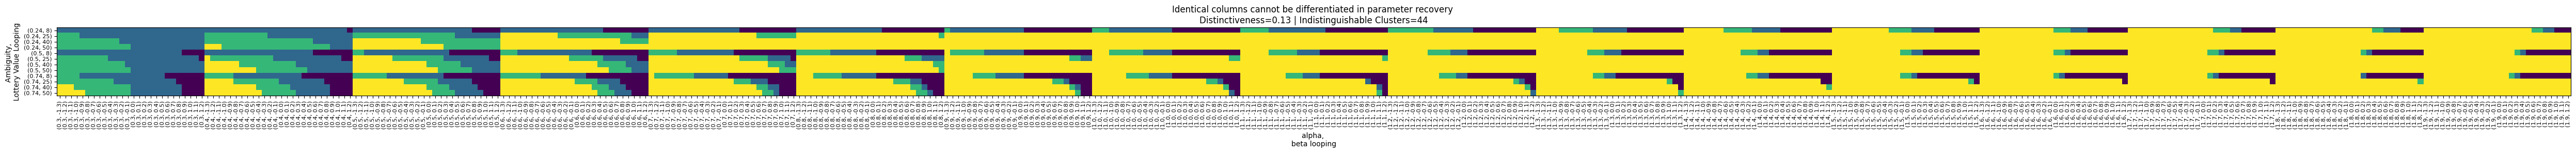

In [10]:
alphas = np.round(np.arange( 0.3,   2,  0.1), 2)
betas  = np.round(np.arange(-1.3, 1.3,  0.1), 2)
ambiguity_range = [0.24, 0.5, 0.74]
tiles = np.zeros((alphas.shape[0] * betas.shape[0], len(ambiguity_range) * len(lottery_range)))

n_trials_per_subgroup = 3

for y2, ambiguity in enumerate(ambiguity_range):
    for x2, lottery in enumerate(lottery_range):
        tile = np.zeros((betas.shape[0], 1))
        x = x2 + len(lottery_range) * y2
        for ia, alpha in enumerate(alphas):
            for kb, beta in enumerate(betas):
                p_ideal = probability_of_lottery_choice(alpha, beta, 1.5, lottery, certain_value, ambiguity, 0.5)
                p_trial_based = np.round(n_trials_per_subgroup * p_ideal, 0) / n_trials_per_subgroup
                tile[kb, 0] = p_trial_based
            y = ia
            tiles[y * tile.shape[0] : y * tile.shape[0] + tile.shape[0], x * tile.shape[1] : x * tile.shape[1] + tile.shape[1]] = tile
print("BETA  n=3")
res = score_distinctiveness(tiles)
heatmap = tiles.T
fig, ax = plt.subplots(figsize=(50, 5))
plt.imshow(heatmap)
plt.title("Identical columns cannot be differentiated in parameter recovery \nDistinctiveness={0:.2f} | Indistinguishable Clusters={1}".format(res[0], res[1]))
plt.xlabel("alpha, \nbeta looping")
beta_ticks = []
for a in alphas:
    beta_ticks.extend(zip([a] * betas.shape[0], betas))

plt.xticks(np.arange(heatmap.shape[1]), beta_ticks, rotation = 90, fontsize = 8)
plt.ylabel("Ambiguity, \nLottery Value Looping")
lottery_ticks = []
for a2 in ambiguity_range:
    lottery_ticks.extend(zip([a2] * len(lottery_range), lottery_range))
plt.yticks(np.arange(heatmap.shape[0]), lottery_ticks, fontsize = 8)
plt.tight_layout()
fig_name = os.path.join(save_dir, "distinctiveness-beta_vAcG-3ambs-3trials.png")
print("Saving to: {}".format(fig_name))
plt.savefig(fig_name)
plt.show()

In [ ]:
import numpy as np
from scipy.stats import bernoulli

MLL_trials = np.array([2.0, 1.0, 1.0]) ## each value represents the sum of lottery choices in that condition subgroup | number of trials per subgroup = 2
MLL_probs  = np.array([1.0, 0.5, 0.7]) ## probability (predictive - not proportion) Ss will chose lottery for each condition subgroup
MLL_total_trials = np.array([2, 2, 2]) ## number of trials per subgroup
print("No black box LL:    ", np.nansum(np.log(MLL_probs) * MLL_trials + np.log(1 - MLL_probs) * (MLL_total_trials - MLL_trials)))

BLL_trials = np.array([1.0, 1.0, 0.0, 1.0, 1.0, 0.0])
BLL_probs  = np.array([1.0, 1.0, 0.5, 0.5, 0.7, 0.7])
print("Bernoulli logpmf LL:", np.nansum(bernoulli.logpmf(BLL_trials, BLL_probs)))

No black box LL:     -2.946942109384559
Bernoulli logpmf LL: -2.946942109384559


#### Beta Distinctiveness: Increasing Number of Trials Per Condition Subgroup (90,000,000)

BETA  n=90,000,000
Distinctiveness: 1.0
Number of indistinguishable clusters: 0
Similarity: 0.0
Saving to: Z:/data/SDDM\derivatives/simulations/crdm/distinctiveness\distinctiveness-beta_vAcG-3ambs-90000000trials.png


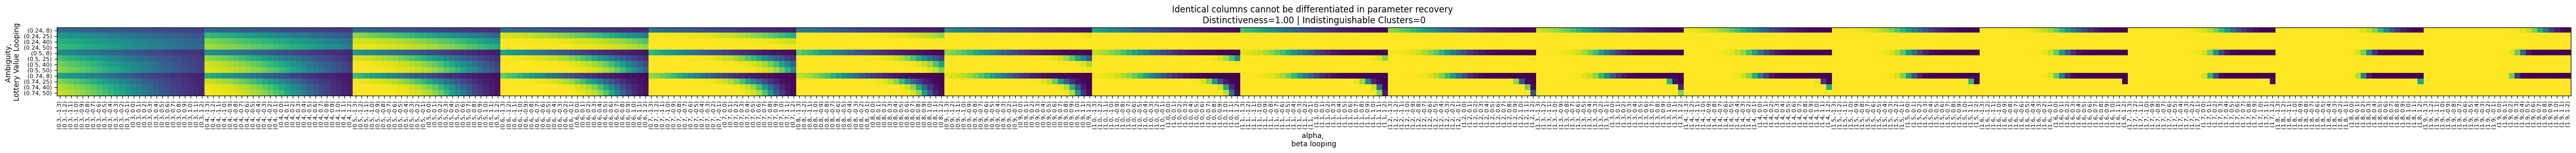

In [14]:
alphas = np.round(np.arange( 0.3,   2,  0.1), 2)
betas  = np.round(np.arange(-1.3, 1.3,  0.1), 2)
ambiguity_range = [0.24, 0.5, 0.74]
tiles = np.zeros((alphas.shape[0] * betas.shape[0], len(ambiguity_range) * len(lottery_range)))

n_trials_per_subgroup = 90000000

for y2, ambiguity in enumerate(ambiguity_range):
    for x2, lottery in enumerate(lottery_range):
        tile = np.zeros((betas.shape[0], 1))
        x = x2 + len(lottery_range) * y2
        for ia, alpha in enumerate(alphas):
            for kb, beta in enumerate(betas):
                p_ideal = probability_of_lottery_choice(alpha, beta, 1.5, lottery, certain_value, ambiguity, 0.5)
                p_trial_based = np.round(n_trials_per_subgroup * p_ideal, 0) / n_trials_per_subgroup
                tile[kb, 0] = p_trial_based
            y = ia
            tiles[y * tile.shape[0] : y * tile.shape[0] + tile.shape[0], x * tile.shape[1] : x * tile.shape[1] + tile.shape[1]] = tile
print("BETA  n=90,000,000")
res = score_distinctiveness(tiles)
heatmap = tiles.T
fig, ax = plt.subplots(figsize=(50, 5))
plt.imshow(heatmap)
plt.title("Identical columns cannot be differentiated in parameter recovery \nDistinctiveness={0:.2f} | Indistinguishable Clusters={1}".format(res[0], res[1]))
plt.xlabel("alpha, \nbeta looping")
beta_ticks = []
for a in alphas:
    beta_ticks.extend(zip([a] * betas.shape[0], betas))
plt.xticks(np.arange(heatmap.shape[1]), beta_ticks, rotation = 90, fontsize = 8)
plt.ylabel("Ambiguity, \nLottery Value Looping")
lottery_ticks = []
for a2 in ambiguity_range:
    lottery_ticks.extend(zip([a2] * len(lottery_range), lottery_range))
plt.yticks(np.arange(heatmap.shape[0]), lottery_ticks, fontsize = 8)
plt.tight_layout()
fig_name = os.path.join(save_dir, "distinctiveness-beta_vAcG-3ambs-90000000trials.png")
print("Saving to: {}".format(fig_name))
plt.savefig(fig_name)
plt.show()

## **Fitting Alpha/Gamma First (post-data collection)**

BETA n=2
Distinctiveness: 0.34615384615384615
Number of indistinguishable clusters: 5
Similarity: 0.6538461538461539
Saving to: Z:/data/SDDM\derivatives/simulations/crdm/distinctiveness\distinctiveness-beta_cAcG-3ambs-2trials.png


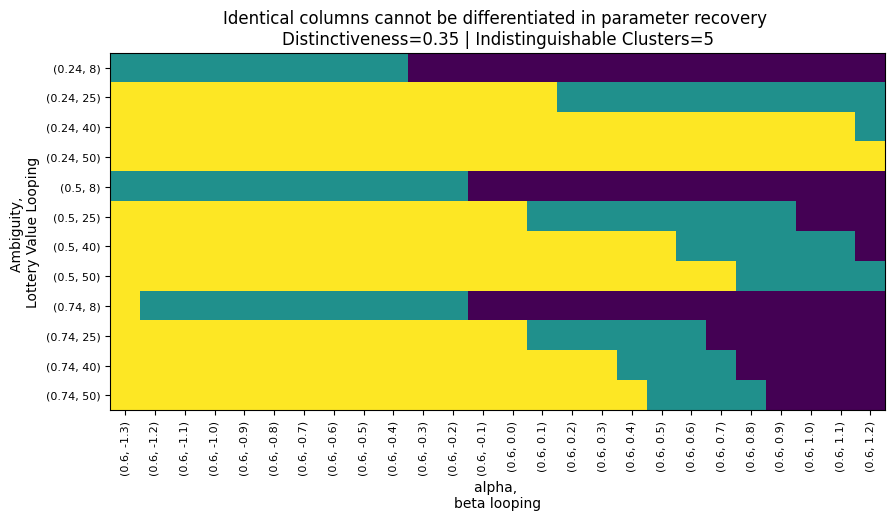

In [21]:
alphas = np.array([0.6])
betas = np.round(np.arange(-1.3, 1.3, 0.1), 2)
ambiguity_range = [0.24, 0.5, 0.74]
tiles = np.zeros((alphas.shape[0] * betas.shape[0], len(ambiguity_range) * len(lottery_range)))

n_trials_per_subgroup = 2

for y2, ambiguity in enumerate(ambiguity_range):
    for x2, lottery in enumerate(lottery_range):
        tile = np.zeros((betas.shape[0], 1))
        x = x2 + len(lottery_range) * y2
        for ia, alpha in enumerate(alphas):
            for kb, beta in enumerate(betas):
                p_ideal = probability_of_lottery_choice(alpha, beta, 1.5, lottery, certain_value, ambiguity, 0.5)
                p_trial_based = np.round(n_trials_per_subgroup * p_ideal, 0) / n_trials_per_subgroup
                tile[kb, 0] = p_trial_based
            y = ia
            tiles[y * tile.shape[0] : y * tile.shape[0] + tile.shape[0], x * tile.shape[1] : x * tile.shape[1] + tile.shape[1]] = tile
print("BETA n=2")
res = score_distinctiveness(tiles)
heatmap = tiles.T
fig, ax = plt.subplots(figsize=(10, 6))
plt.imshow(heatmap)
plt.title("Identical columns cannot be differentiated in parameter recovery \nDistinctiveness={0:.2f} | Indistinguishable Clusters={1}".format(res[0], res[1]))
plt.xlabel("alpha, \nbeta looping")
beta_ticks = []
for a in alphas:
    beta_ticks.extend(zip([a] * betas.shape[0], betas))
plt.xticks(np.arange(heatmap.shape[1]), beta_ticks, rotation = 90, fontsize = 8)
plt.ylabel("Ambiguity, \nLottery Value Looping")
lottery_ticks = []
for a2 in ambiguity_range:
    lottery_ticks.extend(zip([a2] * len(lottery_range), lottery_range))
plt.yticks(np.arange(heatmap.shape[0]), lottery_ticks, fontsize = 8)
fig_name = os.path.join(save_dir, "distinctiveness-beta_cAcG-3ambs-2trials.png")
print("Saving to: {}".format(fig_name))
plt.savefig(fig_name)
plt.show()

BETA n=15
Distinctiveness: 1.0
Number of indistinguishable clusters: 0
Similarity: 0.0
Saving to: Z:/data/SDDM\derivatives/simulations/crdm/distinctiveness\distinctiveness-beta_cAcG-3ambs-15trials.png


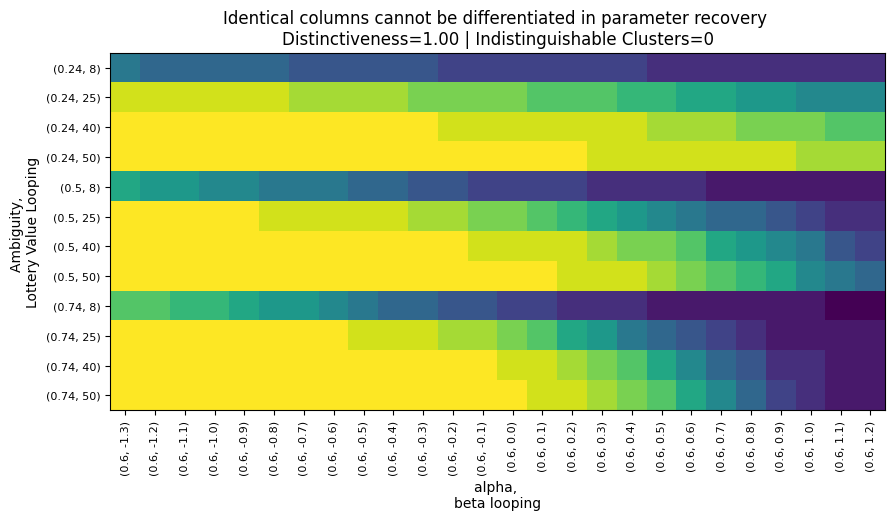

In [20]:
alphas = np.array([0.6])
betas = np.round(np.arange(-1.3, 1.3, 0.1), 2)
ambiguity_range = [0.24, 0.5, 0.74]
tiles = np.zeros((alphas.shape[0] * betas.shape[0], len(ambiguity_range) * len(lottery_range)))

n_trials_per_subgroup = 15

for y2, ambiguity in enumerate(ambiguity_range):
    for x2, lottery in enumerate(lottery_range):
        tile = np.zeros((betas.shape[0], 1))
        x = x2 + len(lottery_range) * y2
        for ia, alpha in enumerate(alphas):
            for kb, beta in enumerate(betas):
                p_ideal = probability_of_lottery_choice(alpha, beta, 1.5, lottery, certain_value, ambiguity, 0.5)
                p_trial_based = np.round(n_trials_per_subgroup * p_ideal, 0) / n_trials_per_subgroup
                tile[kb, 0] = p_trial_based
            y = ia
            tiles[y * tile.shape[0] : y * tile.shape[0] + tile.shape[0], x * tile.shape[1] : x * tile.shape[1] + tile.shape[1]] = tile
print("BETA n=15")
res = score_distinctiveness(tiles)
heatmap = tiles.T
fig, ax = plt.subplots(figsize=(10, 6))
plt.imshow(heatmap)
plt.title("Identical columns cannot be differentiated in parameter recovery \nDistinctiveness={0:.2f} | Indistinguishable Clusters={1}".format(res[0], res[1]))
plt.xlabel("alpha, \nbeta looping")
beta_ticks = []
for a in alphas:
    beta_ticks.extend(zip([a] * betas.shape[0], betas))
plt.xticks(np.arange(heatmap.shape[1]), beta_ticks, rotation = 90, fontsize = 8)
plt.ylabel("Ambiguity, \nLottery Value Looping")
lottery_ticks = []
for a2 in ambiguity_range:
    lottery_ticks.extend(zip([a2] * len(lottery_range), lottery_range))
plt.yticks(np.arange(heatmap.shape[0]), lottery_ticks, fontsize = 8)
fig_name = os.path.join(save_dir, "distinctiveness-beta_cAcG-3ambs-15trials.png")
print("Saving to: {}".format(fig_name))
plt.savefig(fig_name)
plt.show()

In [ ]:
import numpy as np
from scipy.stats import bernoulli

MLL_trials = np.array([2.0, 1.0, 1.0]) ## each value represents the sum of lottery choices in that condition subgroup | number of trials per subgroup = 2
MLL_probs  = np.array([1.0, 0.5, 0.7]) ## probability (predictive - not proportion) Ss will chose lottery for each condition subgroup
MLL_total_trials = np.array([2, 2, 2]) ## number of trials per subgroup
print("No black box LL:    ", np.nansum(np.log(MLL_probs) * MLL_trials + np.log(1 - MLL_probs) * (MLL_total_trials - MLL_trials)))

BLL_trials = np.array([1.0, 1.0, 0.0, 1.0, 1.0, 0.0])
BLL_probs  = np.array([1.0, 1.0, 0.5, 0.5, 0.7, 0.7])
print("Bernoulli logpmf LL:", np.nansum(bernoulli.logpmf(BLL_trials, BLL_probs)))

No black box LL:     -2.946942109384559
Bernoulli logpmf LL: -2.946942109384559


## Stuff I learned after playing around with the parameters
- Alpha is always the simplier of the two parameters (alpha, beta) to fit
    - You can model fit alpha without beta because risky trials don't require beta (held constant in model at A = 0)
    - Fewer free parameters make for easier model fitting
- Proper modeling of alpha (risk tolerance) always requires consideration of gamma (choice stochasticity)
- Proper fitting of beta (ambiguity tolerance) always requires consideration of both alpha and gamma, making beta the most difficult parameter to fit/recover
    - Fitting alpha and gamma together is easier than trying to fit alpha, beta, and gamma together
        - You get better parameter recovery of beta when you fit alpha and gamma first, then separately fit beta (how it's modeled in my simulation/recovery scripts) 